### Test Driven Data Science for Prometheus Anomaly Detector

The below notebook represents an initial prototype for testing the performance of new models on historical data prior to live deployment.

As the aim of this project is to serve as a framework to deploy metric prediction models to detect anomalies in prometheus metrics, we would like to develop a 'testing mode' for the anomaly detector so that we can clearly evaluate the performance of our models prior to deploying them.

For this initial prototype we will implement a somewhat naive approach and auto-label all of the data as anomalous/not anomalous based on a static threshold set by the user. Although this method is inherently problematic (seasonality will be ignored, for example) we are aware of its limitations and it will serve only as a guide. If we had an error-free method of auto-labeling anomalies, we would have our ML model and no more testing would be required. That said, this prototype could be easily modified with a more sophisticated auto-labeling method.

Once the data has been naively auto-labeled, we simulate 24 hours of running the tool, where every hour we train a prophet model on the last week of data and forecast out one hour. We compute the true positive rate for each hour segment, as well as for the entire 24 hour period between our auto-labeled "ground truth" anomalies and the anomalies found by the detector (i.e., if they exceed the upper or lower bounds of the prediction). That said, the inclusion of additional performance metrics, more sophisticated auto-labeling procedures or manual anomaly labeling may improve this testers ability to evaluate models. This is an initial POC.       

This test will require the following configurations:

 - query range
 - training window
 - metric name
 - label_config
 - prom url 
 - prom token
 - threshold


Finally, the user of this test should already have zeroed in on the specific anomalous time frame and metric value they want to test and can provide the entire label_config.

 

In [1]:
# !pip install https://github.com/4n4nd/prometheus-api-client-python/zipball/v0.0.2

In [2]:
import os 
import numpy as np
import pandas as pd
import prometheus_api_client as prom_api
from prometheus_api_client import Metric, MetricsList, PrometheusConnect
import matplotlib.pyplot as plt 
import time
from datetime import datetime
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext dotenv
%dotenv

In [3]:
# This will require the following configurations.

# - query range
# - training window
# - metric name
# - label_config
# - prom url 
# - prom token
# - threshold

# The user of this test should already have zeroed in on the specific timeframe and metric value they want to test
# and can provide the entire label_config.


def prometheus_anoamly_test(start_time, end_time, training_window, metric_name, 
                            label_config, prom_url, prom_token, threshold):
    

    # Read data into memory and convert to a Metric list Object
    
    prom = prom_api.prometheus_connect.PrometheusConnect(url=prom_url, headers={"Authorization": "bearer {}".format(prom_token)}, 
                                                     disable_ssl=True)
    
    metric_data = prom.get_metric_range_data(metric_name=metric_name,
                                         start_time=start_time,
                                         end_time=end_time,
                                         label_config=label_config)
    
    metrics = MetricsList(metric_data)
    m = metrics[0]
    
    num_true_positive = 0
    num_groud_truth = 0
    
    # simulate 24 hours of training and forecasting out one hour to test model.  
    for i in range(24):
        
        # create new df with labels on a metric signal based on simple threshold method. 
        labeled_metric = simple_metric_labeler(m.metric_values, threshold)
        _ , ground_truth = timeseries_train_test_split(labeled_metric, training_window, i)

        # Split data into train test

        train, test = timeseries_train_test_split(m.metric_values, training_window, i)

        # Train model based on training window

        model = train_prophet(train)

        # Forecast 1 hour into the future

        forecast = predict_prophet(model, test)
        
        # Count number of anomalies detected by forecast

        forecasted_anomalies = forecast_anomalies(forecast, test)

        # Compute true positive rate and report ground truth and prediction values
        
        print("ground truth anomlies", sum(ground_truth.label.values))
        print("forecast anomalies", sum(forecasted_anomalies.label.values))
        print("number of data points", len(test.label.values))
        
        true_postive_rate = compute_true_positive_rate(forecasted_anomalies,ground_truth)
        print("true positive rate", true_postive_rate)
        
        num_true_positive += count_true_positives(forecasted_anomalies,ground_truth)
        num_groud_truth += sum(ground_truth.label.values)
        
             
    # compute and return the overall true positive rate 
    total_true_positive_rate = num_true_positive/num_groud_truth
    
    return total_true_positive_rate


def simple_metric_labeler(signal_df, threshold):
    labeld_df = signal_df
    label_column = (signal_df["y"] >= threshold).values.astype(int) 
    labeld_df["label"] = label_column
    return labeld_df

def train_prophet(data):
    model = Prophet()
    model.fit(data)
    return model

def predict_prophet(model, future_time):
    forecast = model.predict(future_time)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

def timeseries_train_test_split(df, training_window, hour):
    
    earliest_time = df["ds"].iloc[0] + pd.Timedelta(hour * 3600, 'sec')
    seconds_training_window = training_window * 604800 # convert to seconds from weeks
    training_window_end = earliest_time + pd.Timedelta(seconds_training_window, 'sec')
    test_window_end = training_window_end + pd.Timedelta(3600, 'sec') # add an hour imeseries_train_test_split(df, t
    
    train = df[df['ds'] <= training_window_end]
    test = df[df['ds'] > training_window_end]
    test = test[test['ds'] < test_window_end]
    
    print(training_window_end, "training window end")
    print(test_window_end, "test window end")
    
    return train, test

def forecast_anomalies(forecast_df, signal_df):
    detections = []
    for y, yhat_upper, yhat_lower in zip(signal_df.y,forecast_df.yhat_upper, forecast_df.yhat_lower):
        
        if y <= yhat_lower:
            detections.append(1)
        
        elif y >= yhat_upper:
            detections.append(1)
        
        else:
            detections.append(0)
    
    detected_df = forecast_df
    detected_df["label"] = detections
    return detected_df    

def compute_true_positive_rate(forecasted_anomalies, labeled_anomalies):
    
    num_true_positive = count_true_positives(forecasted_anomalies, labeled_anomalies)
    true_postive_rate = num_true_positive/sum(labeled_anomalies.label.values)
    
    return true_postive_rate

def count_true_positives(forecast_anomalies, labeled_anomalies):
        
        num_true_positive = sum((forecast_anomalies.label.values == 1) & 
                            (labeled_anomalies.label.values == 1))
        
        return num_true_positive

    

In [4]:
# example configurations
metric_name="name"
start_time = datetime.fromtimestamp(1000000000)
end_time = datetime.fromtimestamp(1000000001)
label_config={}

prom_url = 'prometheus route'
prom_token = 'prometheus access token'
training_window='integer representing weeks'
threshold = 'float'

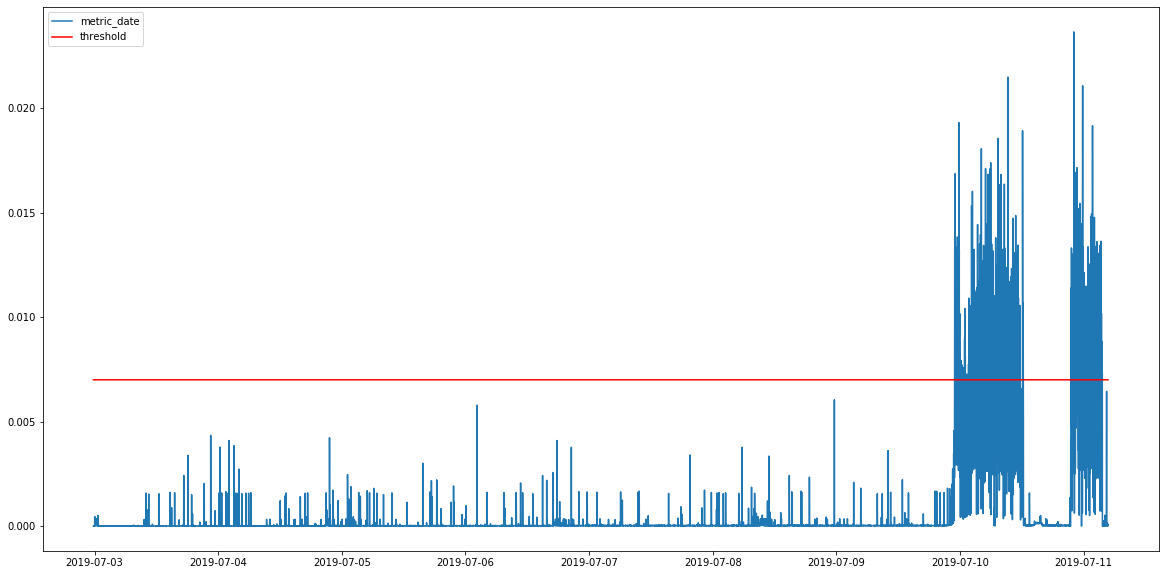

In [6]:
prom = prom_api.prometheus_connect.PrometheusConnect(url=prom_url, headers={"Authorization": "bearer {}".format(prom_token)}, 
                                                 disable_ssl=True)

metric_data = prom.get_metric_range_data(metric_name=metric_name,
                                     start_time=start_time,
                                     end_time=end_time,
                                     label_config=label_config)

metrics = MetricsList(metric_data)
m = metrics[0]

plt.figure(figsize=(20,10))
plt.plot(m.metric_values.ds, m.metric_values.y)
plt.plot(m.metric_values.ds, np.ones_like(m.metric_values.y)*0.007, c="red")
plt.legend(["metric_date","threshold"])
plt.show()

In [7]:
prometheus_anoamly_test(start_time, end_time,training_window, metric_name, label_config, prom_url, prom_token, threshold)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


2019-07-09 23:47:00.825000048 training window end
2019-07-10 00:47:00.825000048 test window end
2019-07-09 23:47:00.825000048 training window end
2019-07-10 00:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 13
forecast anomalies 48
number of data points 59
true positive rate 1.0
2019-07-10 00:47:00.825000048 training window end
2019-07-10 01:47:00.825000048 test window end
2019-07-10 00:47:00.825000048 training window end
2019-07-10 01:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 8
forecast anomalies 47
number of data points 59
true positive rate 1.0
2019-07-10 01:47:00.825000048 training window end
2019-07-10 02:47:00.825000048 test window end
2019-07-10 01:47:00.825000048 training window end
2019-07-10 02:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 21
forecast anomalies 49
number of data points 59
true positive rate 1.0
2019-07-10 02:47:00.825000048 training window end
2019-07-10 03:47:00.825000048 test window end
2019-07-10 02:47:00.825000048 training window end
2019-07-10 03:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 33
forecast anomalies 53
number of data points 59
true positive rate 1.0
2019-07-10 03:47:00.825000048 training window end
2019-07-10 04:47:00.825000048 test window end
2019-07-10 03:47:00.825000048 training window end
2019-07-10 04:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 30
forecast anomalies 52
number of data points 59
true positive rate 1.0
2019-07-10 04:47:00.825000048 training window end
2019-07-10 05:47:00.825000048 test window end
2019-07-10 04:47:00.825000048 training window end
2019-07-10 05:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 29
forecast anomalies 44
number of data points 59
true positive rate 1.0
2019-07-10 05:47:00.825000048 training window end
2019-07-10 06:47:00.825000048 test window end
2019-07-10 05:47:00.825000048 training window end
2019-07-10 06:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 23
forecast anomalies 47
number of data points 59
true positive rate 1.0
2019-07-10 06:47:00.825000048 training window end
2019-07-10 07:47:00.825000048 test window end
2019-07-10 06:47:00.825000048 training window end
2019-07-10 07:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 31
forecast anomalies 46
number of data points 59
true positive rate 1.0
2019-07-10 07:47:00.825000048 training window end
2019-07-10 08:47:00.825000048 test window end
2019-07-10 07:47:00.825000048 training window end
2019-07-10 08:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 25
forecast anomalies 41
number of data points 59
true positive rate 1.0
2019-07-10 08:47:00.825000048 training window end
2019-07-10 09:47:00.825000048 test window end
2019-07-10 08:47:00.825000048 training window end
2019-07-10 09:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 16
forecast anomalies 34
number of data points 59
true positive rate 0.9375
2019-07-10 09:47:00.825000048 training window end
2019-07-10 10:47:00.825000048 test window end
2019-07-10 09:47:00.825000048 training window end
2019-07-10 10:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 26
forecast anomalies 37
number of data points 59
true positive rate 0.8461538461538461
2019-07-10 10:47:00.825000048 training window end
2019-07-10 11:47:00.825000048 test window end
2019-07-10 10:47:00.825000048 training window end
2019-07-10 11:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 23
forecast anomalies 45
number of data points 59
true positive rate 0.8695652173913043
2019-07-10 11:47:00.825000048 training window end
2019-07-10 12:47:00.825000048 test window end
2019-07-10 11:47:00.825000048 training window end
2019-07-10 12:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 7
forecast anomalies 49
number of data points 59
true positive rate 1.0
2019-07-10 12:47:00.825000048 training window end
2019-07-10 13:47:00.825000048 test window end
2019-07-10 12:47:00.825000048 training window end
2019-07-10 13:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 0
forecast anomalies 59
number of data points 59
true positive rate nan
2019-07-10 13:47:00.825000048 training window end
2019-07-10 14:47:00.825000048 test window end
2019-07-10 13:47:00.825000048 training window end
2019-07-10 14:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 0
forecast anomalies 59
number of data points 59
true positive rate nan
2019-07-10 14:47:00.825000048 training window end
2019-07-10 15:47:00.825000048 test window end
2019-07-10 14:47:00.825000048 training window end
2019-07-10 15:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 0
forecast anomalies 59
number of data points 59
true positive rate nan
2019-07-10 15:47:00.825000048 training window end
2019-07-10 16:47:00.825000048 test window end
2019-07-10 15:47:00.825000048 training window end
2019-07-10 16:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 0
forecast anomalies 59
number of data points 59
true positive rate nan
2019-07-10 16:47:00.825000048 training window end
2019-07-10 17:47:00.825000048 test window end
2019-07-10 16:47:00.825000048 training window end
2019-07-10 17:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 0
forecast anomalies 59
number of data points 59
true positive rate nan
2019-07-10 17:47:00.825000048 training window end
2019-07-10 18:47:00.825000048 test window end
2019-07-10 17:47:00.825000048 training window end
2019-07-10 18:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 0
forecast anomalies 59
number of data points 59
true positive rate nan
2019-07-10 18:47:00.825000048 training window end
2019-07-10 19:47:00.825000048 test window end
2019-07-10 18:47:00.825000048 training window end
2019-07-10 19:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 0
forecast anomalies 59
number of data points 59
true positive rate nan
2019-07-10 19:47:00.825000048 training window end
2019-07-10 20:47:00.825000048 test window end
2019-07-10 19:47:00.825000048 training window end
2019-07-10 20:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 0
forecast anomalies 59
number of data points 59
true positive rate nan
2019-07-10 20:47:00.825000048 training window end
2019-07-10 21:47:00.825000048 test window end
2019-07-10 20:47:00.825000048 training window end
2019-07-10 21:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 8
forecast anomalies 52
number of data points 59
true positive rate 1.0
2019-07-10 21:47:00.825000048 training window end
2019-07-10 22:47:00.825000048 test window end
2019-07-10 21:47:00.825000048 training window end
2019-07-10 22:47:00.825000048 test window end


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


ground truth anomlies 31
forecast anomalies 44
number of data points 59
true positive rate 1.0
2019-07-10 22:47:00.825000048 training window end
2019-07-10 23:47:00.825000048 test window end
2019-07-10 22:47:00.825000048 training window end
2019-07-10 23:47:00.825000048 test window end
ground truth anomlies 36
forecast anomalies 42
number of data points 59
true positive rate 0.9444444444444444


0.9722222222222222

The overall true positive rate for this 24 hour period (between 2019-07-09 23:47:00 and 2019-07-10 23:47:00) was 0.97. Meaning that we correctly identified 97% of the anomalies present in the dataset. 

Of the known anomalies in our dataset, almost all were correctly identified. However, we can also see that this model, making forecasts on the anomalous 07/10 portion of the above time series(or the last eighth of our data), is skewed heavily towards over-reporting anomalies, and in many cases generated a relatively high false positive rate. In general, this is something that we will have to take into consideration, and future iterations of this test can include a false positive rate metric as well. 

That said, I think the above example shows that this test provides a good method for indicating how well a model is at identifying anomalies in simple prometheus metrics.  